**Segmentation of the dermoscopic images using BCDU-Net**

**Importing required libraries**

In [ ]:
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import os
import scipy.misc as sc
import keras
import sys
import pandas as pd
import imageio as io
from zipfile import ZipFile
from keras.models import Model
from keras.optimizers import *
from keras.layers import *
import tensorflow as tf
from keras.callbacks import *
from sklearn.metrics import *
import matplotlib.pyplot as plt

**Mounting the google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading training and validation data and mask

In [ ]:
root_path = '/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Segmentation/'

In [ ]:
train_img_dir = root_path+'/Data/train_images/train/'
train_mask_dir = root_path+'/Data/train_masks/train/'

img_list = os.listdir(train_img_dir)
img_list.sort()  #Very important to sort as we want to match images and masks with same number. 
msk_list = os.listdir(train_mask_dir)
msk_list.sort()
num_images = len(os.listdir(train_img_dir))
print("Total number of training images are: ", num_images)

Total number of training images are:  14314


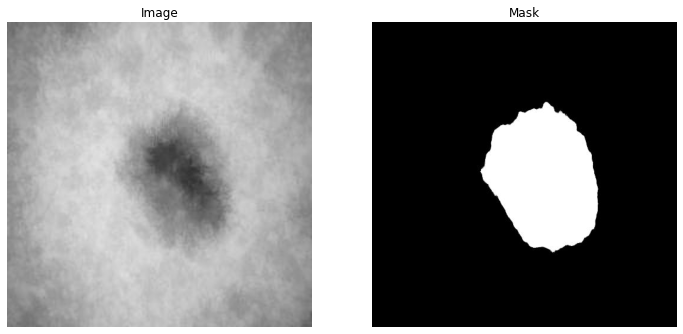

In [ ]:
import random
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 0)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)
mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.axis("off")
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.axis("off")
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
seed=24
batch_size= 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
def preprocess_data(img, mask):
    img = cv2.normalize(img, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
    mask = mask/255  
    return (img, mask)


def trainGenerator(train_img_path, train_mask_path):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        target_size=(256,256),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size=(256,256),
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask)
        yield (img, mask)

In [ ]:
train_img_path = root_path+'/Data/train_images/'
train_mask_path = root_path+'/Data/train_masks/'
train_img_gen = trainGenerator(train_img_path, train_mask_path)

val_img_path = root_path+'/Data/val_images/'
val_mask_path = root_path+'/Data/val_masks/'
val_img_gen = trainGenerator(val_img_path, val_mask_path)



In [ ]:
x, y = train_img_gen.__next__()

Found 14314 images belonging to 1 classes.
Found 14314 images belonging to 1 classes.


In [ ]:
x_val, y_val = val_img_gen.__next__()

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [ ]:
num_train_imgs = len(os.listdir(root_path+'/Data/train_images/train'))
num_val_images = len(os.listdir(root_path+'/Data/val_images/val'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

# Bidirectional ConvLstm U-net with 3 densely connected convolutions layers

In [ ]:
# considering 3 densely connected convolutions
def BCDU_net_D3(input_size = (256,256,3)):
  N = input_size[0]
  inputs = Input(input_size)

  #ENCODING PATH

  #FIRST ROW

  #First conv layer with 64 filters
  conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = BatchNormalization()(conv1)
  #second conv layer with 64 filters
  conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  conv1 = BatchNormalization()(conv1)
  #MAX pooling for first row
  pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

  #SECOND ROW

  #First conv layer with 128 filters
  conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = BatchNormalization()(conv2)
  #second conv layer with 128 filters
  conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  conv2 = BatchNormalization()(conv2)
  #MAX pooling for second row
  pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

  #THIRD ROW

  #First conv layer with 256 filters
  conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  #second conv layer with 256 filters
  conv3 = BatchNormalization()(conv3)
  conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  conv3 = BatchNormalization()(conv3)
  # removing randomly selected neuron
  drop3 = tf.keras.layers.Dropout(0.5)(conv3)
  #MAX pooling for third row
  pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

  #BLOCK 1
  conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
  conv4 = BatchNormalization()(conv4)
  conv4_1 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  conv4_1 = BatchNormalization()(conv4_1)
  drop4_1 = tf.keras.layers.Dropout(0.5)(conv4_1)

  #BLOCK 2
  conv4_2 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)  
  conv4_2 = BatchNormalization()(conv4_2)   
  conv4_2 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
  conv4_2=BatchNormalization()(conv4_2)
  conv4_2 = tf.keras.layers.Dropout(0.5)(conv4_2)
  conv4_2 = BatchNormalization()(conv4_2)

  #BLOCK 3
  merge_dense = concatenate([conv4_2,conv4_1], axis = 3)
  conv4_3 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)  
  conv4_3 = BatchNormalization()(conv4_3)   
  conv4_3 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
  conv4_3 = BatchNormalization()(conv4_3)
  drop4_3 = tf.keras.layers.Dropout(0.5)(conv4_3)

  #DECODING PATH

  #THIRD ROW
  up6 = tf.keras.layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
  up6 = BatchNormalization(axis=3)(up6)
  up6 = Activation('relu')(up6)

  x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
  x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
  merge6  = concatenate([x1,x2], axis = 1) 
  merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
  
  conv6 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = BatchNormalization()(conv6)
  conv6 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  conv6 = BatchNormalization()(conv6)

  #SECOND ROW
  up7 = tf.keras.layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
  up7 = BatchNormalization(axis=3)(up7)
  up7 = Activation('relu')(up7)

  x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
  x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
  merge7  = concatenate([x1,x2], axis = 1) 
  merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
      
  conv7 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = BatchNormalization()(conv7)
  conv7 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  conv7 = BatchNormalization()(conv7)

  #FIRST ROW
  up8 = tf.keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
  up8 = BatchNormalization(axis=3)(up8)
  up8 = Activation('relu')(up8)    

  x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
  x2 = Reshape(target_shape=(1, N, N, 64))(up8)
  merge8  = concatenate([x1,x2], axis = 1) 
  merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
  
  conv8 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = BatchNormalization()(conv8)
  conv8 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  conv8 = BatchNormalization()(conv8)

  # FINAL OUTPUT
  conv8 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  conv8 = BatchNormalization()(conv8)
  conv9 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv8)

  model = Model(inputs = inputs, outputs = conv9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model


**Building the model**

In [ ]:
model = BCDU_net_D3(input_size = (256,256,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

**Training the model**

In [ ]:
# Loading the saved model
from keras.models import load_model
model=load_model('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Segmentation/20_epochs_NEW_BCDUnet_model.h5',compile=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
nb_epoch = 30

mcp_save = ModelCheckpoint('weight_isic18', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
history = model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=nb_epoch,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch, callbacks=[mcp_save, reduce_lr_loss] )

Epoch 1/30
894/894 [==============================] - 6005s 7s/step - loss: 0.0885 - accuracy: 0.9352 - val_loss: 0.1404 - val_accuracy: 0.9182 - lr: 1.0000e-05
Epoch 2/30
894/894 [==============================] - 925s 1s/step - loss: 0.0875 - accuracy: 0.9356 - val_loss: 0.1706 - val_accuracy: 0.9084 - lr: 1.0000e-05
Epoch 3/30
894/894 [==============================] - 924s 1s/step - loss: 0.0866 - accuracy: 0.9359 - val_loss: 0.1539 - val_accuracy: 0.9121 - lr: 1.0000e-05
Epoch 4/30
894/894 [==============================] - 924s 1s/step - loss: 0.0863 - accuracy: 0.9358 - val_loss: 0.1589 - val_accuracy: 0.9107 - lr: 1.0000e-05
Epoch 5/30
894/894 [==============================] - 924s 1s/step - loss: 0.0860 - accuracy: 0.9360 - val_loss: 0.1500 - val_accuracy: 0.9184 - lr: 1.0000e-05
Epoch 6/30
894/894 [==============================] - 924s 1s/step - loss: 0.0854 - accuracy: 0.9363 - val_loss: 0.1601 - val_accuracy: 0.9143 - lr: 1.0000e-05
Epoch 7/30
894/894 [===================

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Segmentation/50_epochs_NEW_BCDUnet_model.h5')
print("Unet Model saved")

Unet Model saved


 # Predicting accuracy of the model using validation images


In [ ]:
val_img_path_1 = root_path+'/Data/val_images/val/'

In [ ]:
height,width = 256,256
channels = 3

In [ ]:
Data_val_2018 = np.zeros([100, height, width, channels])
Mask_val_2018 = np.zeros([100, height, width])

In [ ]:
os.chdir(val_img_path_1)
val_images = glob.glob('*.jpg')
print(len(val_images))

100


In [ ]:
def dataset_normalized(imgs):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized

In [ ]:
for idx in range(len(val_images)):
    img = io.imread(val_images[idx])
    Data_val_2018[idx, :,:,:] = img
    b = val_images[idx] 
    img2 = io.imread(root_path+'/Data/val_masks/val/'+b)
    Mask_val_2018[idx, :,:] = img2

In [ ]:
val_data  = dataset_normalized(Data_val_2018)
val_mask  = Mask_val_2018 /255.

**Predictions for the validation set**

In [ ]:
predictions_val = model.predict(val_data, batch_size=16, verbose=1)

## calculating confusion matrix ##

# predicted scores
y_scores = predictions_val.reshape(predictions_val.shape[0]*predictions_val.shape[1]*predictions_val.shape[2]*predictions_val.shape[3], 1)
# true scores

y_true = val_mask.reshape(val_mask.shape[0]*val_mask.shape[1]*val_mask.shape[2], 1)
y_scores = np.where(y_scores>0.5, 1, 0)

y_true   = np.where(y_true>0.5, 1, 0)

7/7 [==============================] - 3s 480ms/step


**Calculating performance metrics**

In [ ]:
# setting threshold as 0.5
threshold_confusion = 0.5
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)

# Computing accuracy

accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))

# Computing Specificity

specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))

# Computing Sensitivity 

sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))

# Computing Precision

precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))

## Computing F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

Global Accuracy: 0.9268548583984375
Specificity: 0.9527894175603016
Sensitivity: 0.8562018666860639
Precision: 0.8694022659260533

F1 score (F-measure): 0.8627515765857334


**Predictions for some of the validation samples**

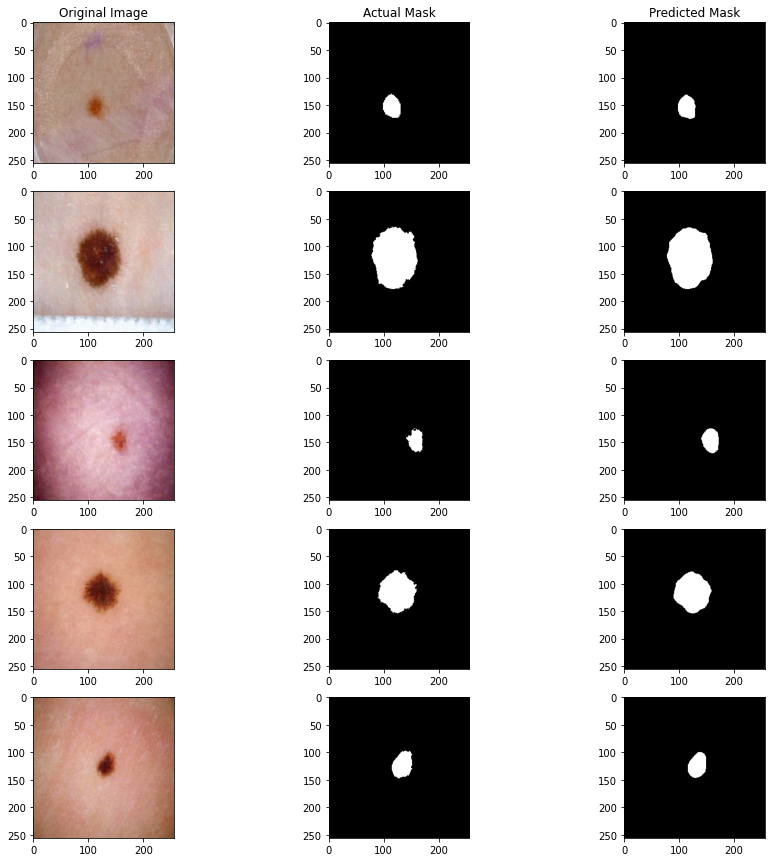

In [ ]:
threshold = 300
predictions = np.where(predictions_val>0.5, 1, 0)

val_mask     = np.where(val_mask>0.5, 1, 0)
good_prediction = np.zeros([predictions.shape[0],1], np.uint8)
id_m = 0
for idx in range(predictions.shape[0]):
    esti_sample = predictions[idx]
    true_sample = val_mask[idx]
    esti_sample = esti_sample.reshape(esti_sample.shape[0]*esti_sample.shape[1]*esti_sample.shape[2], 1)
    true_sample = true_sample.reshape(true_sample.shape[0]*true_sample.shape[1], 1)
    er = 0
    for idy in range(true_sample.shape[0]):
        if esti_sample[idy] != true_sample[idy]:
           er = er +1
    if er <threshold:
       good_prediction[id_m] = idx    
       id_m += 1   

fig,ax = plt.subplots(5,3,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Actual Mask')
ax[0, 2].title.set_text('Predicted Mask')

for idx in range(5):
    ax[idx, 0].imshow(np.uint8(val_data[good_prediction[idx,0]]))
    ax[idx, 1].imshow(np.squeeze(val_mask[good_prediction[idx,0]]), cmap='gray')
    ax[idx, 2].imshow(np.squeeze(predictions[good_prediction[idx,0]]), cmap='gray')

# Prediction for the test data


## Prediction and segment extraction for the test images

In [ ]:
from keras.models import load_model
model=load_model('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/50_epochs_NEW_BCDUnet_model.h5')

In [ ]:
# Generating folders for the corresponding masks and extracted regions 

classify_path = '/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/'
os.chdir(classify_path) 

os.mkdir('Mask_AK')
os.mkdir('Mask_BCC')
os.mkdir('Mask_BKL')
os.mkdir('Mask_DF')
os.mkdir('Mask_MEL')
os.mkdir('Mask_NV')
os.mkdir('Mask_SCC')
os.mkdir('Mask_VASC')


os.mkdir('Reg_AK')
os.mkdir('Reg_BCC')
os.mkdir('Reg_BKL')
os.mkdir('Reg_DF')
os.mkdir('Reg_MEL')
os.mkdir('Reg_NV')
os.mkdir('Reg_SCC')
os.mkdir('Reg_VASC')

### DF

In [ ]:
os.chdir('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Pro_DF/')
test_images = glob.glob('*.jpg')
test_images = sorted(test_images)
print(len(test_images))

239


In [ ]:
Data_test_2018 = np.zeros([239, 256, 256, 3])

In [ ]:
for idx in range(len(test_images)):
    img = io.imread(test_images[idx])
    Data_test_2018[idx, :,:,:] = img

15/15 [==============================] - 4s 301ms/step


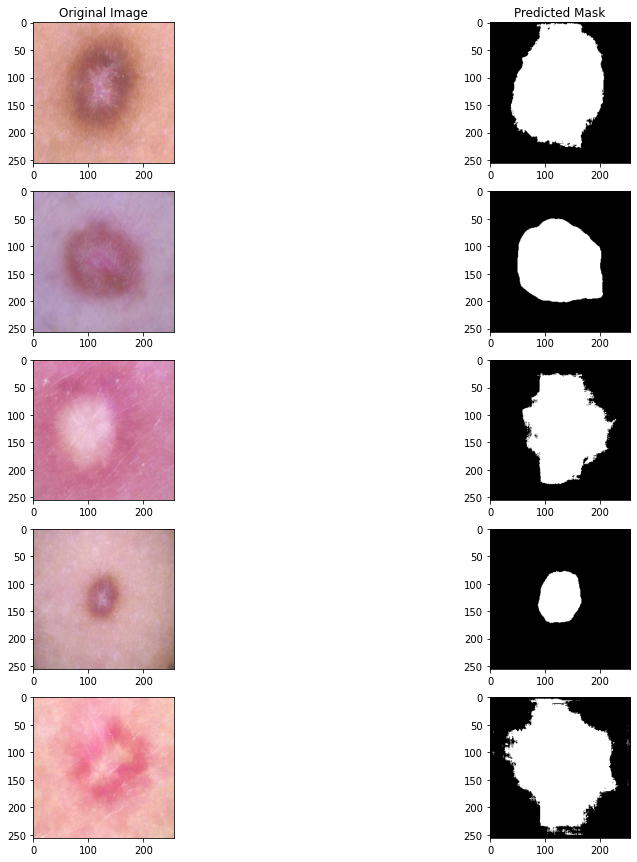

In [ ]:
predictions = model.predict(Data_test_2018, batch_size=16, verbose=1)
predictions = np.where(predictions>0.5, 1, 0)

predictions = predictions*255

## Displaying the image and the corresponding mask

fig,ax = plt.subplots(5,2,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')

for i in range(5):
  ax[i, 0].imshow(np.uint8(Data_test_2018[i]))
  ax[i, 1].imshow(np.squeeze(predictions[i]), cmap='gray')


In [ ]:
for i in range(len(predictions)):
  cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Mask_DF/'+test_images[i], predictions[i])

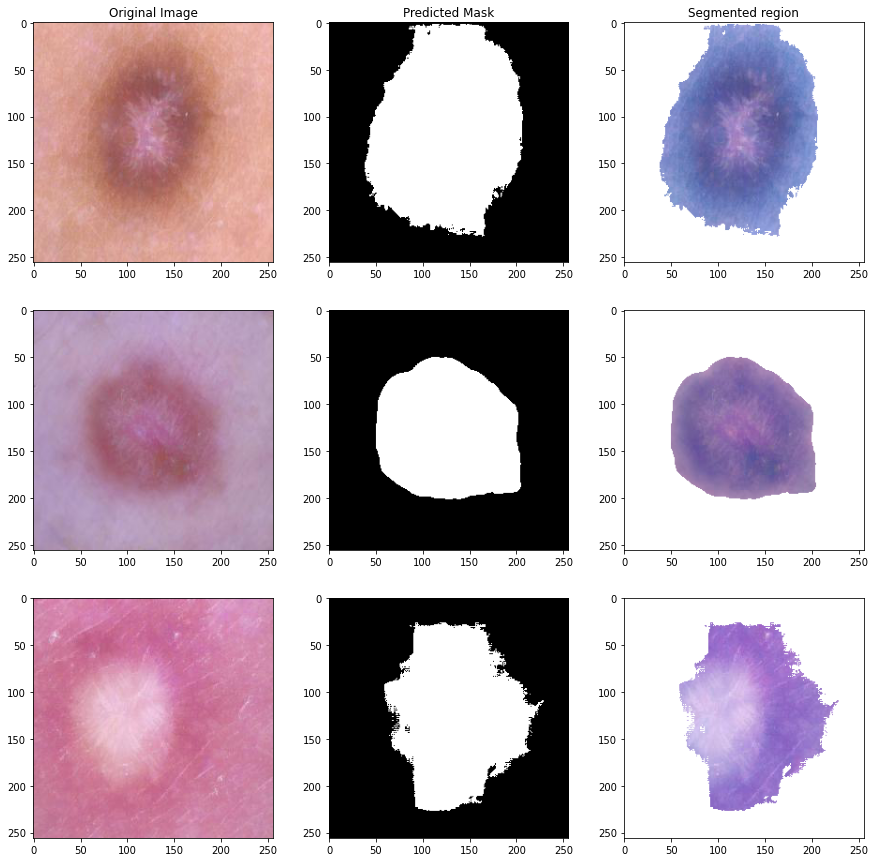

In [ ]:
# Extracting the lesion regions alone

fig,ax = plt.subplots(3,3,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')
ax[0, 2].title.set_text('Segmented region')

y=0

for i in range(len(predictions)):
  ROI = Data_test_2018[i].copy();
  BW = predictions[i]

  img2 = np.zeros([np.array(BW).shape[0],np.array(BW).shape[1],3])

  img2[:,:,0] = predictions[i][:,:,0] 
  img2[:,:,1] = predictions[i][:,:,0]
  img2[:,:,2] = predictions[i][:,:,0]
  BW = img2

  ROI[BW == 0] = 255;
  img = np.array(ROI, dtype=np.uint8)

  ROI = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Reg_DF/'+test_images[i], ROI) 
  if(y<3):
    ax[y, 0].imshow(np.uint8(Data_test_2018[y]))
    ax[y, 1].imshow(np.squeeze(predictions[y]), cmap='gray')
    ax[y, 2].imshow(np.uint8(ROI))
    y+=1


### MEL

In [ ]:
os.chdir('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Pro_MEL/')
test_images = glob.glob('*.jpg')
test_images = sorted(test_images)
print(len(test_images))

4522


In [ ]:
Data_test_2018 = np.zeros([4522, 256, 256, 3])

In [ ]:
for idx in range(len(test_images)):
    img = io.imread(test_images[idx])
    Data_test_2018[idx, :,:,:] = img

283/283 [==============================] - 87s 309ms/step


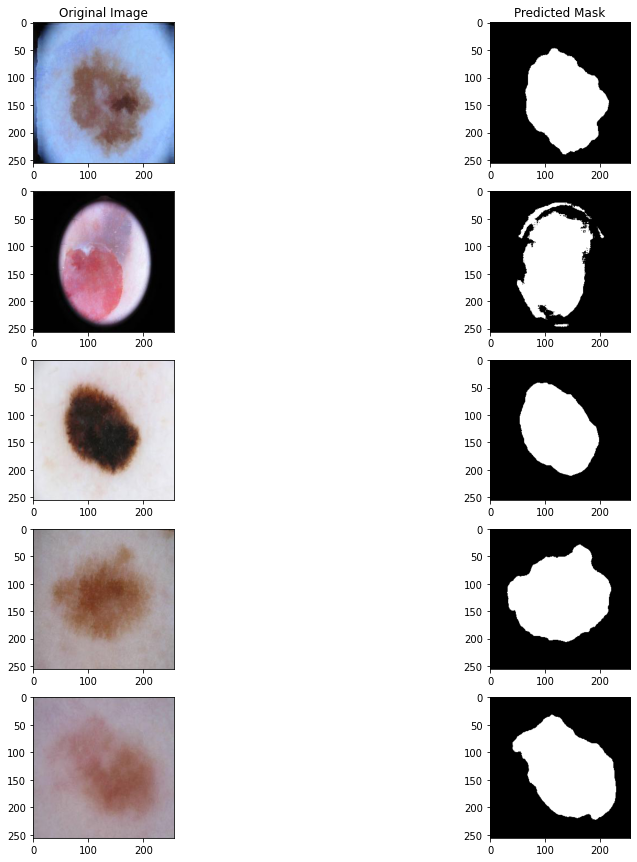

In [ ]:
predictions = model.predict(Data_test_2018, batch_size=16, verbose=1)
predictions = np.where(predictions>0.5, 1, 0)

predictions = predictions*255

## Displaying the image and the corresponding mask

fig,ax = plt.subplots(5,2,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')

for i in range(5):
  ax[i, 0].imshow(np.uint8(Data_test_2018[i]))
  ax[i, 1].imshow(np.squeeze(predictions[i]), cmap='gray')


In [ ]:
for i in range(len(predictions)):
  cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Mask_MEL/'+test_images[i], predictions[i])

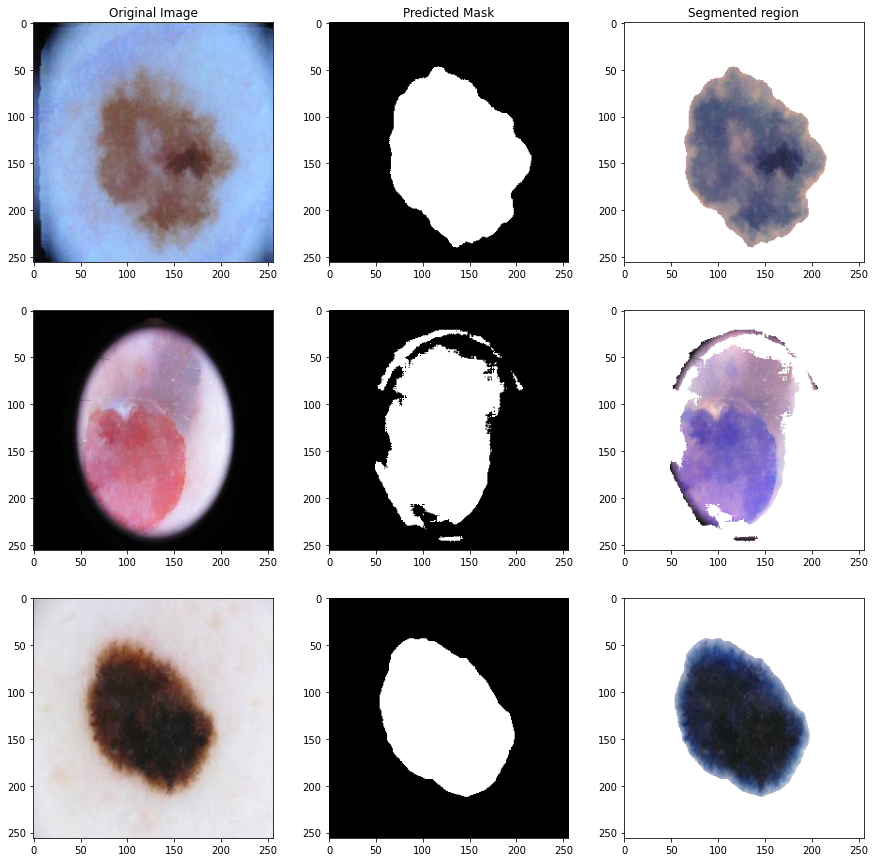

In [ ]:
# Extracting the lesion regions alone

fig,ax = plt.subplots(3,3,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')
ax[0, 2].title.set_text('Segmented region')

y=0

for i in range(len(predictions)):
  ROI = Data_test_2018[i].copy();
  BW = predictions[i]

  img2 = np.zeros([np.array(BW).shape[0],np.array(BW).shape[1],3])

  img2[:,:,0] = predictions[i][:,:,0] 
  img2[:,:,1] = predictions[i][:,:,0]
  img2[:,:,2] = predictions[i][:,:,0]
  BW = img2

  ROI[BW == 0] = 255;
  img = np.array(ROI, dtype=np.uint8)

  ROI = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Reg_MEL/'+test_images[i], ROI) 
  if(y<3):
    ax[y, 0].imshow(np.uint8(Data_test_2018[y]))
    ax[y, 1].imshow(np.squeeze(predictions[y]), cmap='gray')
    ax[y, 2].imshow(ROI)
    y+=1


  


### VASC

In [ ]:
os.chdir('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Pro_VASC/')
test_images = glob.glob('*.jpg')
test_images = sorted(test_images)
print(len(test_images))

253


In [ ]:
Data_test_2018 = np.zeros([253, 256, 256, 3])

In [ ]:
for idx in range(len(test_images)):
    img = io.imread(test_images[idx])
    Data_test_2018[idx, :,:,:] = img

16/16 [==============================] - 7s 487ms/step


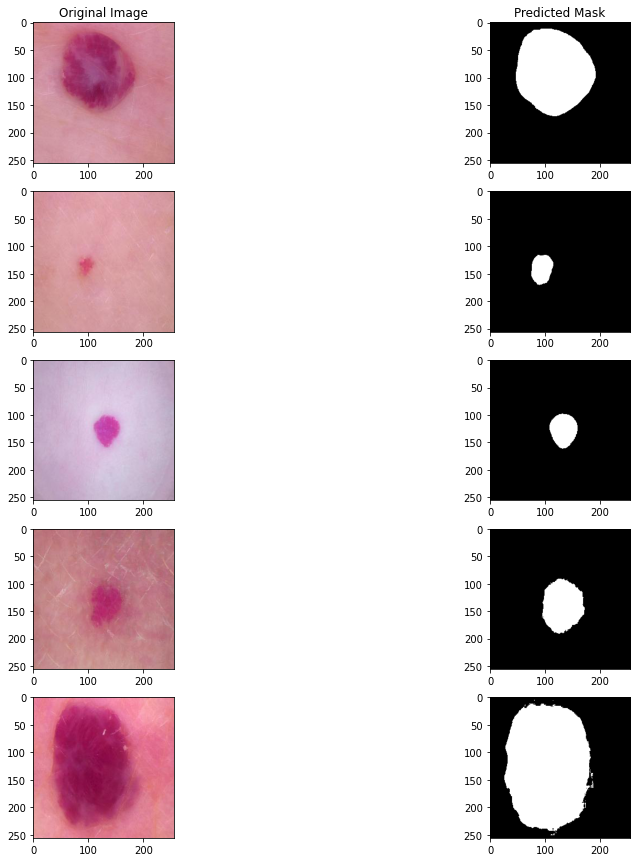

In [ ]:
predictions = model.predict(Data_test_2018, batch_size=16, verbose=1)
predictions = np.where(predictions>0.5, 1, 0)

predictions = predictions*255

## Displaying the image and the corresponding mask

fig,ax = plt.subplots(5,2,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')

for i in range(5):
  ax[i, 0].imshow(np.uint8(Data_test_2018[i]))
  ax[i, 1].imshow(np.squeeze(predictions[i]), cmap='gray')


In [ ]:
for i in range(len(predictions)):
  cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Mask_VASC/'+test_images[i], predictions[i])

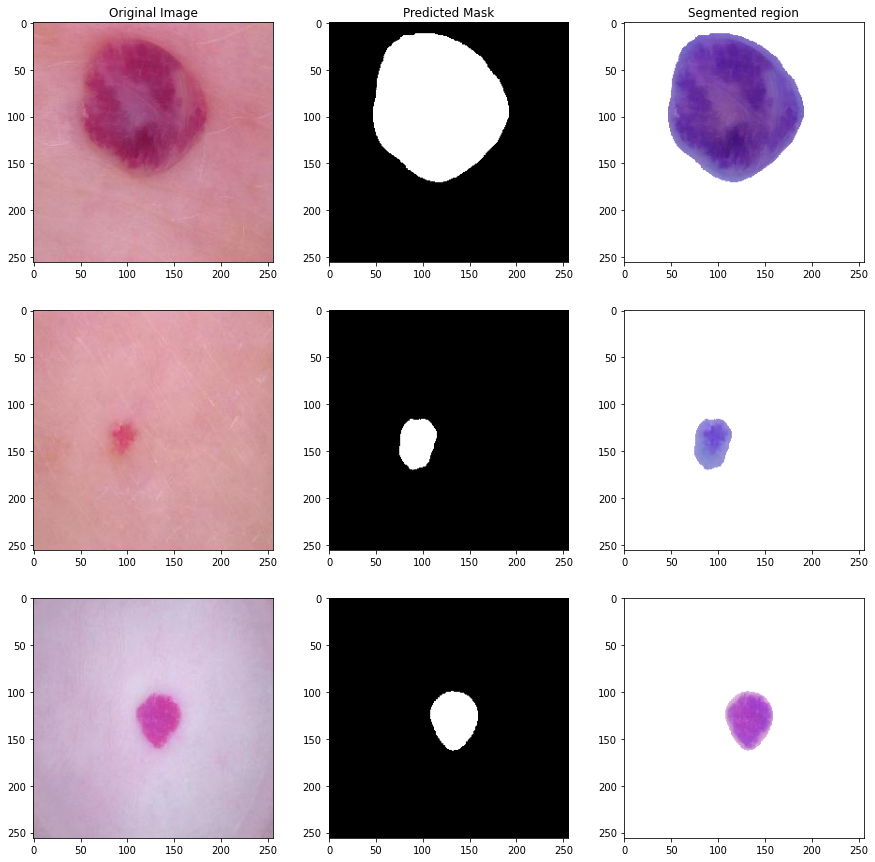

In [ ]:
# Extracting the lesion regions alone

fig,ax = plt.subplots(3,3,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')
ax[0, 2].title.set_text('Segmented region')

y=0

for i in range(len(predictions)):
  ROI = Data_test_2018[i].copy();
  BW = predictions[i]

  img2 = np.zeros([np.array(BW).shape[0],np.array(BW).shape[1],3])

  img2[:,:,0] = predictions[i][:,:,0] 
  img2[:,:,1] = predictions[i][:,:,0]
  img2[:,:,2] = predictions[i][:,:,0]
  BW = img2

  ROI[BW == 0] = 255;
  img = np.array(ROI, dtype=np.uint8)

  ROI = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixels = np.array(ROI)
  #cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Reg_VASC/'+test_images[i], ROI) 
  if(y<3):
    ax[y, 0].imshow(np.uint8(Data_test_2018[y]))
    ax[y, 1].imshow(np.squeeze(predictions[y]), cmap='gray')
    ax[y, 2].imshow(pixels)
    y+=1


### AK

In [ ]:
os.chdir('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Pro_AK/')
test_images = glob.glob('*.jpg')
test_images = sorted(test_images)
print(len(test_images))

867


In [ ]:
Data_test_2018 = np.zeros([867, 256, 256, 3])

In [ ]:
for idx in range(len(test_images)):
    img = io.imread(test_images[idx])
    Data_test_2018[idx, :,:,:] = img

55/55 [==============================] - 17s 317ms/step


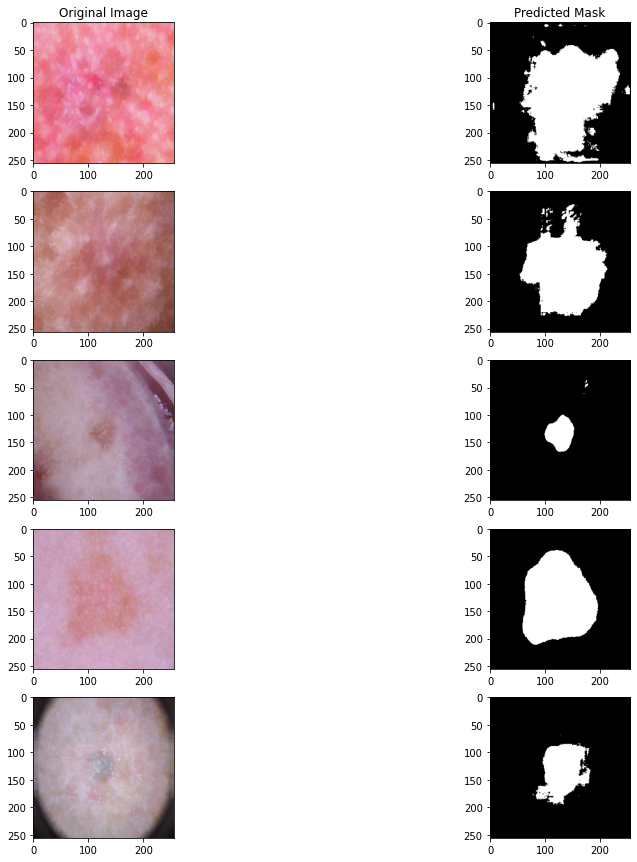

In [ ]:
predictions = model.predict(Data_test_2018, batch_size=16, verbose=1)
predictions = np.where(predictions>0.5, 1, 0)

predictions = predictions*255

## Displaying the image and the corresponding mask

fig,ax = plt.subplots(5,2,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')

for i in range(5):
  ax[i, 0].imshow(np.uint8(Data_test_2018[i]))
  ax[i, 1].imshow(np.squeeze(predictions[i]), cmap='gray')


In [ ]:
for i in range(len(predictions)):
  cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Mask_AK/'+test_images[i], predictions[i])

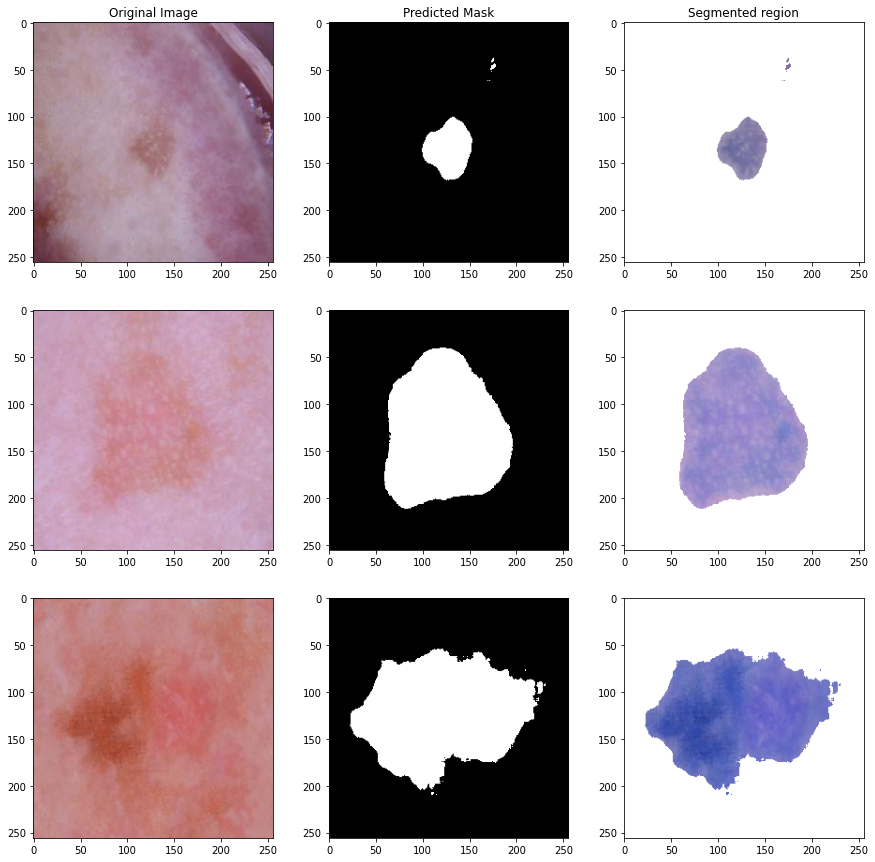

In [ ]:
# Extracting the lesion regions alone

fig,ax = plt.subplots(3,3,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')
ax[0, 2].title.set_text('Segmented region')

y=0

for i in range(len(predictions)):
  ROI = Data_test_2018[i].copy();
  BW = predictions[i]

  img2 = np.zeros([np.array(BW).shape[0],np.array(BW).shape[1],3])

  img2[:,:,0] = predictions[i][:,:,0] 
  img2[:,:,1] = predictions[i][:,:,0]
  img2[:,:,2] = predictions[i][:,:,0]
  BW = img2

  ROI[BW == 0] = 255;
  img = np.array(ROI, dtype=np.uint8)

  ROI = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixels = np.array(ROI)
  #cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Reg_AK/'+test_images[i], ROI) 
  if(y<3 and (i==3 or i==2 or i==8)):
    ax[y, 0].imshow(np.uint8(Data_test_2018[i]))
    ax[y, 1].imshow(np.squeeze(predictions[i]), cmap='gray')
    ax[y, 2].imshow(pixels)
    y+=1


### BCC

In [ ]:
os.chdir('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Pro_BCC/')
test_images = glob.glob('*.jpg')
test_images = sorted(test_images)
print(len(test_images))

3323


In [ ]:
Data_test_2018 = np.zeros([3323, 256, 256, 3])

In [ ]:
for idx in range(len(test_images)):
    img = io.imread(test_images[idx])
    Data_test_2018[idx, :,:,:] = img

208/208 [==============================] - 65s 312ms/step


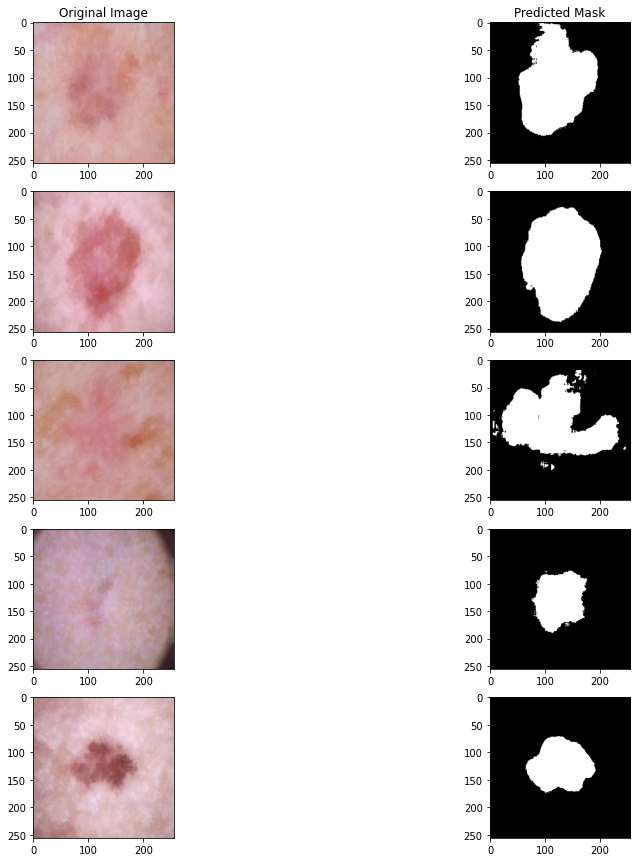

In [ ]:
predictions = model.predict(Data_test_2018, batch_size=16, verbose=1)
predictions = np.where(predictions>0.5, 1, 0)

predictions = predictions*255

## Displaying the image and the corresponding mask

fig,ax = plt.subplots(5,2,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')

for i in range(5):
  ax[i, 0].imshow(np.uint8(Data_test_2018[i]))
  ax[i, 1].imshow(np.squeeze(predictions[i]), cmap='gray')


In [ ]:
for i in range(len(predictions)):
  cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Mask_BCC/'+test_images[i], predictions[i])

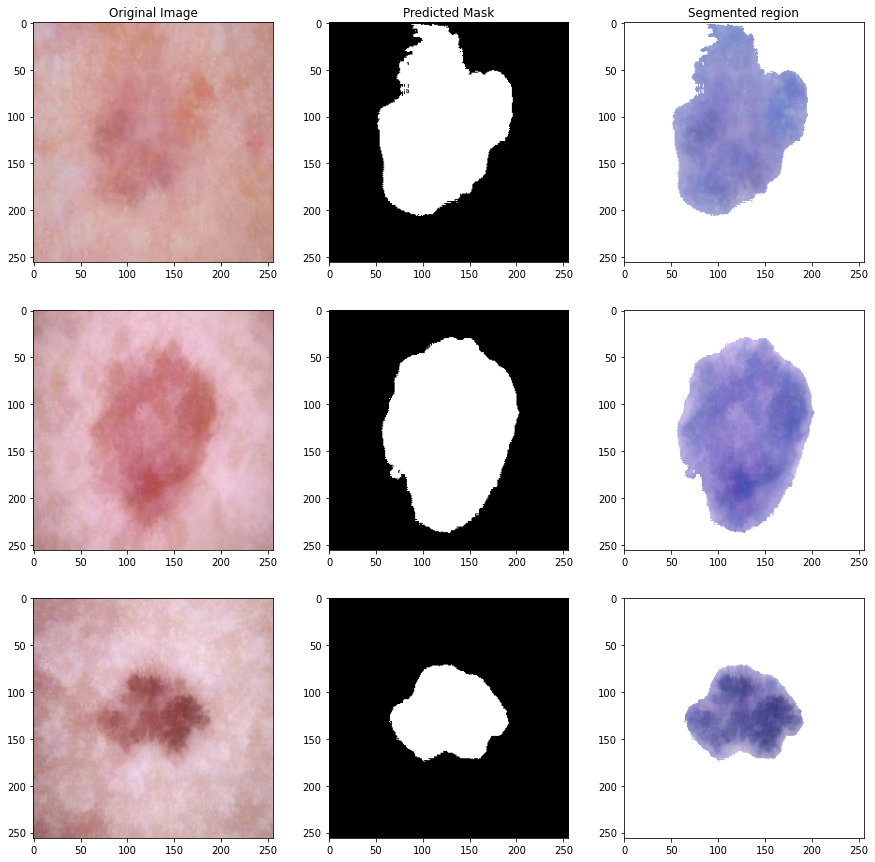

In [ ]:
# Extracting the lesion regions alone

fig,ax = plt.subplots(3,3,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')
ax[0, 2].title.set_text('Segmented region')

y=0

for i in range(len(predictions)):
  ROI = Data_test_2018[i].copy();
  BW = predictions[i]

  img2 = np.zeros([np.array(BW).shape[0],np.array(BW).shape[1],3])

  img2[:,:,0] = predictions[i][:,:,0] 
  img2[:,:,1] = predictions[i][:,:,0]
  img2[:,:,2] = predictions[i][:,:,0]
  BW = img2

  ROI[BW == 0] = 255;
  img = np.array(ROI, dtype=np.uint8)

  ROI = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixels = np.array(ROI)
  #cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Reg_BCC/'+test_images[i], ROI) 
  if(y<3 and (i==0 or i==1 or i==4)):
    ax[y, 0].imshow(np.uint8(Data_test_2018[i]))
    ax[y, 1].imshow(np.squeeze(predictions[i]), cmap='gray')
    ax[y, 2].imshow(pixels)
    y+=1


### BKL

In [ ]:
os.chdir('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Pro_BKL/')
test_images = glob.glob('*.jpg')
test_images = sorted(test_images)
print(len(test_images))

2624


In [ ]:
Data_test_2018 = np.zeros([2624, 256, 256, 3])

In [ ]:
for idx in range(len(test_images)):
    img = io.imread(test_images[idx])
    Data_test_2018[idx, :,:,:] = img

164/164 [==============================] - 131s 677ms/step


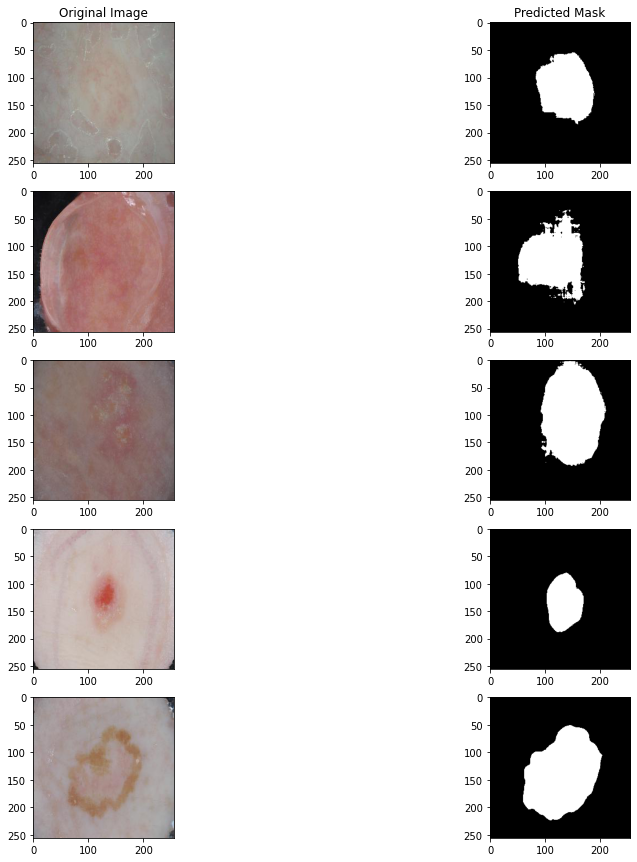

In [ ]:
predictions = model.predict(Data_test_2018, batch_size=16, verbose=1)
predictions = np.where(predictions>0.5, 1, 0)

predictions = predictions*255

## Displaying the image and the corresponding mask

fig,ax = plt.subplots(5,2,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')

for i in range(5):
  ax[i, 0].imshow(np.uint8(Data_test_2018[i]))
  ax[i, 1].imshow(np.squeeze(predictions[i]), cmap='gray')


In [ ]:
for i in range(len(predictions)):
  cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Mask_BKL/'+test_images[i], predictions[i])

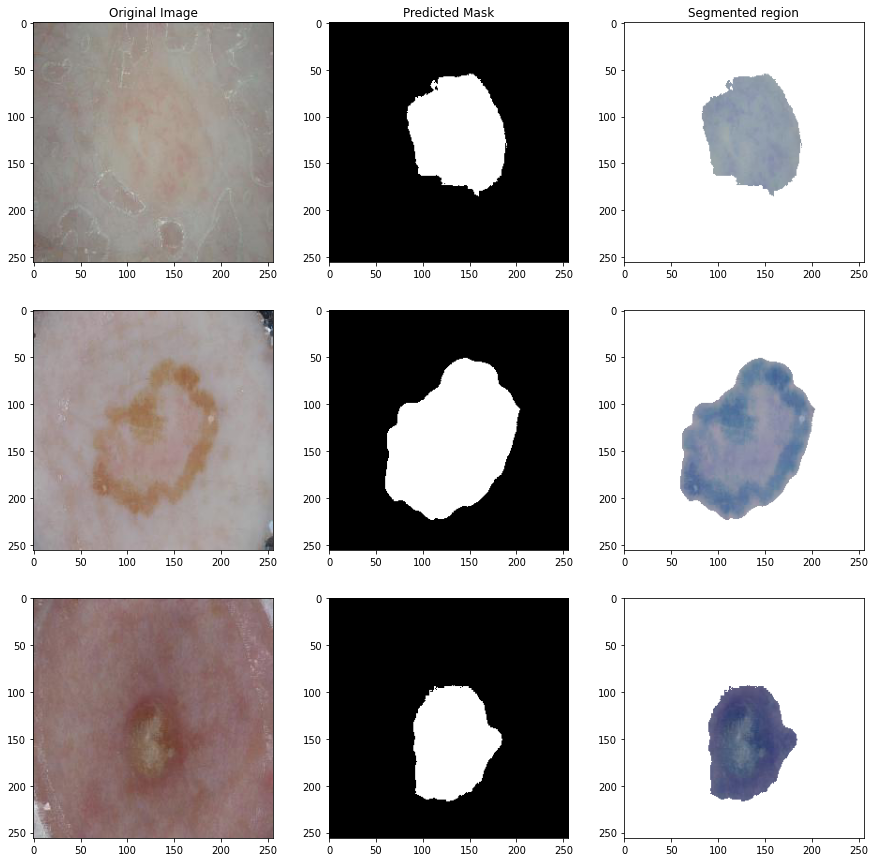

In [ ]:
# Extracting the lesion regions alone

fig,ax = plt.subplots(3,3,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')
ax[0, 2].title.set_text('Segmented region')

y=0

for i in range(len(predictions)):
  ROI = Data_test_2018[i].copy();
  BW = predictions[i]

  img2 = np.zeros([np.array(BW).shape[0],np.array(BW).shape[1],3])

  img2[:,:,0] = predictions[i][:,:,0] 
  img2[:,:,1] = predictions[i][:,:,0]
  img2[:,:,2] = predictions[i][:,:,0]
  BW = img2

  ROI[BW == 0] = 255;
  img = np.array(ROI, dtype=np.uint8)

  ROI = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixels = np.array(ROI)
  #cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Reg_BKL/'+test_images[i], ROI) 
  if(y<3 and (i==0 or i==7 or i==4)):
    ax[y, 0].imshow(np.uint8(Data_test_2018[i]))
    ax[y, 1].imshow(np.squeeze(predictions[i]), cmap='gray')
    ax[y, 2].imshow(pixels)
    y+=1


### SCC

In [ ]:
os.chdir('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Pro_SCC/')
test_images = glob.glob('*.jpg')
test_images = sorted(test_images)
print(len(test_images))

628


In [ ]:
Data_test_2018 = np.zeros([628, 256, 256, 3])

In [ ]:
for idx in range(len(test_images)):
    img = io.imread(test_images[idx])
    Data_test_2018[idx, :,:,:] = img

40/40 [==============================] - 27s 658ms/step


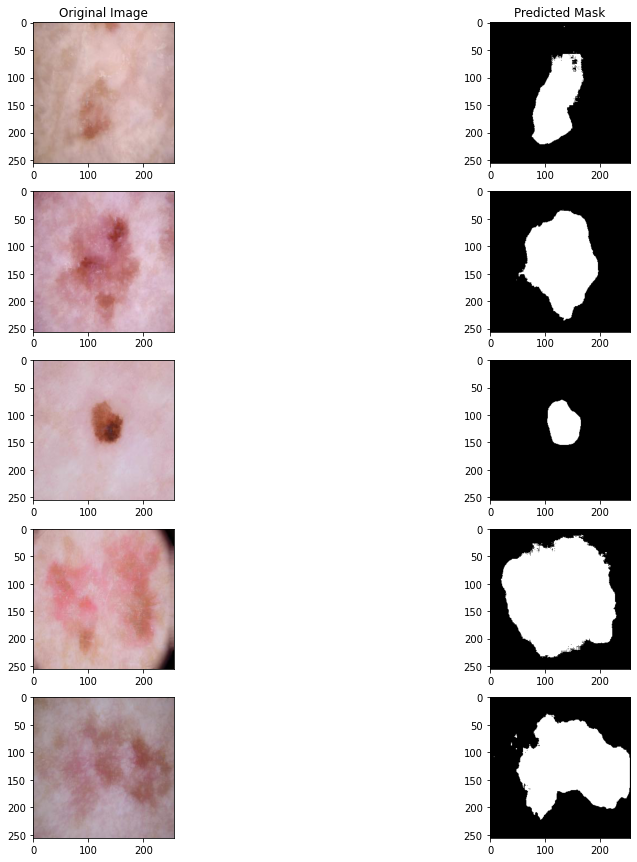

In [ ]:
predictions = model.predict(Data_test_2018, batch_size=16, verbose=1)
predictions = np.where(predictions>0.5, 1, 0)

predictions = predictions*255

## Displaying the image and the corresponding mask

fig,ax = plt.subplots(5,2,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')

for i in range(5):
  ax[i, 0].imshow(np.uint8(Data_test_2018[i]))
  ax[i, 1].imshow(np.squeeze(predictions[i]), cmap='gray')


In [ ]:
for i in range(len(predictions)):
  cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Mask_SCC/'+test_images[i], predictions[i])

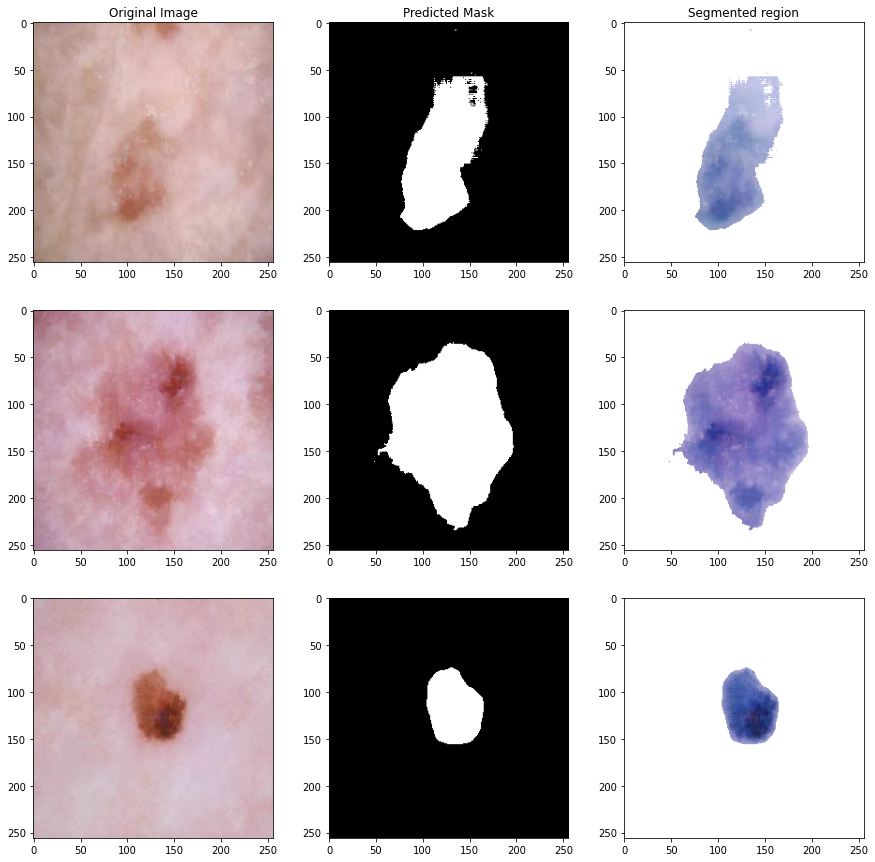

In [ ]:
# Extracting the lesion regions alone

fig,ax = plt.subplots(3,3,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')
ax[0, 2].title.set_text('Segmented region')

y=0

for i in range(len(predictions)):
  ROI = Data_test_2018[i].copy();
  BW = predictions[i]

  img2 = np.zeros([np.array(BW).shape[0],np.array(BW).shape[1],3])

  img2[:,:,0] = predictions[i][:,:,0] 
  img2[:,:,1] = predictions[i][:,:,0]
  img2[:,:,2] = predictions[i][:,:,0]
  BW = img2

  ROI[BW == 0] = 255;
  img = np.array(ROI, dtype=np.uint8)

  ROI = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixels = np.array(ROI)
  #cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Reg_SCC/'+test_images[i], ROI) 
  if(y<3):
    ax[y, 0].imshow(np.uint8(Data_test_2018[i]))
    ax[y, 1].imshow(np.squeeze(predictions[i]), cmap='gray')
    ax[y, 2].imshow(pixels)
    y+=1


### NV

In [ ]:
os.chdir('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Pro_NV/')
test_images = glob.glob('*.jpg')
test_images = sorted(test_images)
print(len(test_images))

12875


In [ ]:
Data_test_2018 = np.zeros([12875, 256, 256, 3])

In [ ]:
ct=0
for idx in range(len(test_images)):
    img = io.imread(test_images[idx])
    Data_test_2018[ct, :,:,:] = img
    ct+=1

63/63 [==============================] - 41s 666ms/step


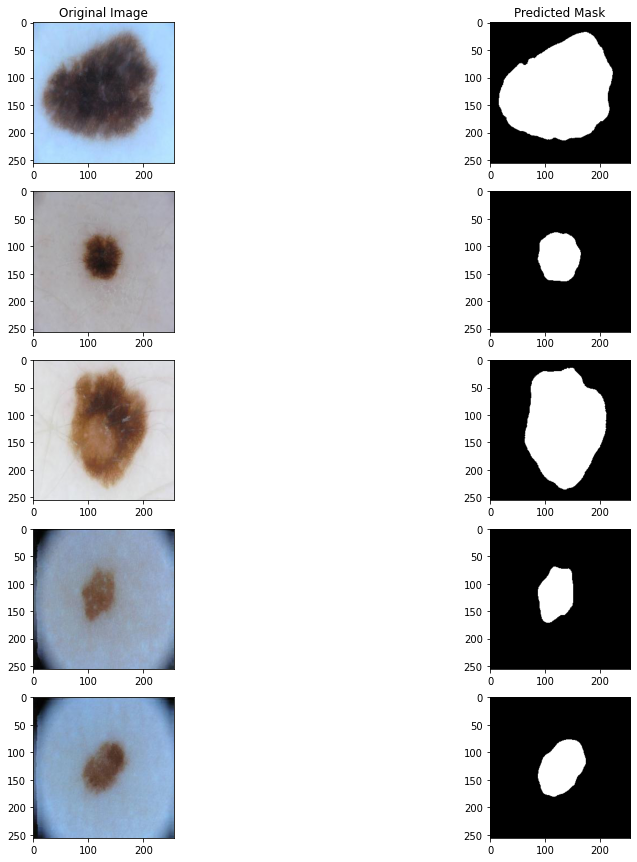

In [ ]:
predictions = model.predict(Data_test_2018, batch_size=16, verbose=1)
predictions = np.where(predictions>0.5, 1, 0)

predictions = predictions*255

## Displaying the image and the corresponding mask

fig,ax = plt.subplots(5,2,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')

for i in range(5):
  ax[i, 0].imshow(np.uint8(Data_test_2018[i]))
  ax[i, 1].imshow(np.squeeze(predictions[i]), cmap='gray')


In [ ]:
# Saving masks for the test images in folders
ct=0
for i in range(len(predictions)):
  cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Mask_NV/'+test_images[ct], predictions[i])
  ct+=1

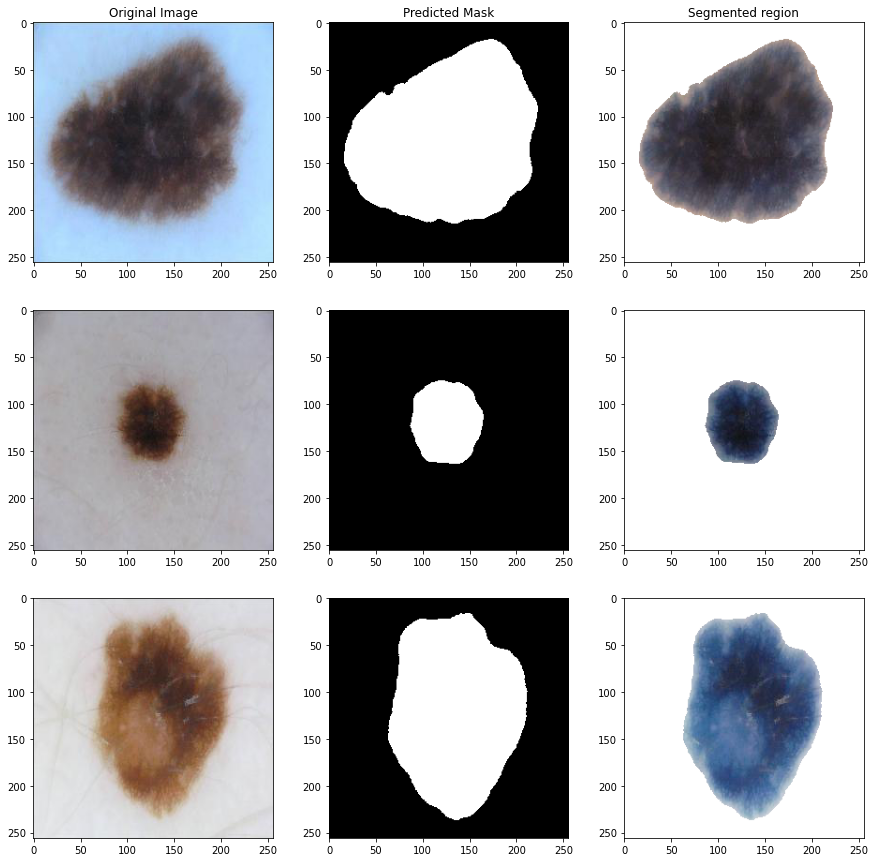

In [ ]:
# Extracting the lesion regions alone

fig,ax = plt.subplots(3,3,figsize=[15,15])

ax[0, 0].title.set_text('Original Image')
ax[0, 1].title.set_text('Predicted Mask')
ax[0, 2].title.set_text('Segmented region')

y=0

for i in range(len(predictions)):
  ROI = Data_test_2018[i].copy();
  BW = predictions[i]

  img2 = np.zeros([np.array(BW).shape[0],np.array(BW).shape[1],3])

  img2[:,:,0] = predictions[i][:,:,0] 
  img2[:,:,1] = predictions[i][:,:,0]
  img2[:,:,2] = predictions[i][:,:,0]
  BW = img2

  ROI[BW == 0] = 255;
  img = np.array(ROI, dtype=np.uint8)

  ROI = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixels = np.array(ROI)
  #cv2.imwrite('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Reg_NV/'+test_images[i], ROI) 
  if(y<3):
    ax[y, 0].imshow(np.uint8(Data_test_2018[i]))
    ax[y, 1].imshow(np.squeeze(predictions[i]), cmap='gray')
    ax[y, 2].imshow(pixels)
    y+=1
